# Application the Bert-like NLP model for a regression task

The goal of this study is explore the approach using the NLP model for the regression problem. 
The task is to try to predict the price of a product by its name. In this case, we take one category of goods - photographic lenses. The fact is that the name of a photo lens usually contains characteristics that affect the cost. Using a text classification model, we will extract embeddings and then apply classic ML models to these embeddings for final price predictions.  
For this study, a dataset was collected from the Ebay. Dataset consists more than 400,000 rows with two columns - the text name of the product and its cost in US dollars. The dataset includes products with a fixed price only.
The dataset has been pre-processed. Duplicate lines have been removed, as well as lines with an incorrect price value. For example, when a price range was specified. Some of the products do not match the lenses category. For example, there are some items from the accessories or cameras categories. Additional data cleaning is not provided in this work.  
  
---
  
What can be improved  

Apply gpu-based ML models evaluation. In this step we use only Ridge Regression model. SVM and KNN models takes too much time to evaluate on CPU.

To clean the dataset. For example, using semi-supervised learning methods. It also possible to make a classifier to determine whether a given product a lens or a camera or something else. To do this the additional datasets should be collected.  

There are mnay ovepriced items which can be listed for years without being sold. So for the real selling price the auction data and final prices should be used. But it'll take much more time to collect such data of an equivalent size.

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.4 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import torch
from tqdm import notebook
import transformers as ppb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge


tf.test.gpu_device_name()

'/device:GPU:0'

### Data Loading

In [3]:
! gdown 1ke85ydpWrJsSC_lk-4Rdbrz1JyEVZWvA

Downloading...
From: https://drive.google.com/uc?id=1ke85ydpWrJsSC_lk-4Rdbrz1JyEVZWvA
To: /content/data_lens.csv
100% 29.9M/29.9M [00:00<00:00, 37.1MB/s]


In [4]:
data = pd.read_csv('/content/data_lens.csv')

In [5]:
data.shape

(419669, 2)

Slightly reducing the number of rows because we'll train on batches.

In [6]:
data = data.sample(419500)

Exploring the title length distribution

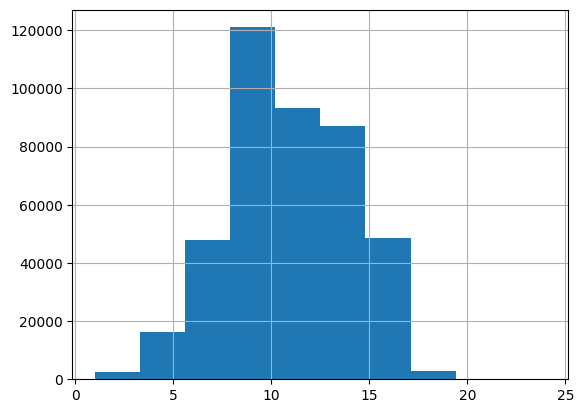

In [7]:
data['item_title'].apply(lambda x: len(x.split())).hist(bins=10);

Maximum length

In [8]:
data['item_title'].apply(lambda x: len(x.split())).max()

24

Distribution of price values

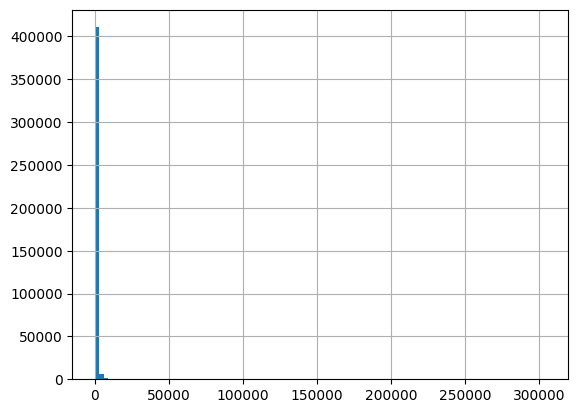

In [9]:
data['price'].hist(bins=100);

Most of the values are closer to 0, there are some extremely large values. Let's take a logarithm.

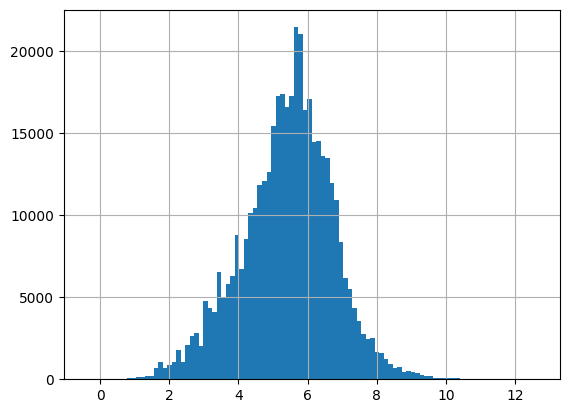

In [10]:
np.log(data['price']).hist(bins=100);

After log transformation, the distribution began to look like a normal one. At the stage of training linear models, it is therefore better to use the logarithmic transformation of the target feature.

### Spliting data into training and test sets

In [11]:
train, test = train_test_split(data, test_size=0.2)

### Feature Extraction

Checking the computation device

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

if device.type == "cuda":
    gpu_device_name = torch.cuda.get_device_name(0)
    gpu_memory_alloc_GB = torch.cuda.memory_allocated(0) / 1024**3
    gpu_memory_cached_GB = torch.cuda.memory_reserved(0) / 1024**3

    print(f"Device name: {gpu_device_name}")
    print(f"Memory allocated: {np.round(gpu_memory_alloc_GB, 1)} GB")
    print(f"Memory cached: {np.round(gpu_memory_cached_GB, 1)} GB")

Using device: cuda:0
Device name: Tesla T4
Memory allocated: 0.0 GB
Memory cached: 0.0 GB


Extracting embeddings from the item titles. Bert model finetuned on mixed datasest.

In [13]:
def tokenization(dataset, max_len=25, batch_size=100):
    #  Tokenization
    tokenizer = ppb.AutoTokenizer.from_pretrained(
        "rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")
    
    tokenized = dataset['item_title'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    tokenized = tokenized.apply(lambda x: x[0:max_len] if len(x) > max_len else x)
    
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    
    # Attention mask
    data_padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(data_padded != 0, 1, 0)
    
    # Embedding extraction
    model = ppb.AutoModel.from_pretrained(
        "rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment"
        ).to(device)
    
    embeddings = []
    for i in notebook.tqdm(range(data_padded.shape[0] // batch_size)):
        batch = torch.LongTensor(data_padded[batch_size * i : batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(
                        attention_mask[batch_size * i : batch_size * (i + 1)]
                        ).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
        embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy().astype('float16'))
    
    X = np.concatenate(embeddings)
    y = dataset['price']
    return X, y

In [14]:
X_train, y_train = tokenization(train, max_len=25, batch_size=100)

Some weights of the model checkpoint at rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3356 [00:00<?, ?it/s]

In [15]:
X_test, y_test = tokenization(test, max_len=25, batch_size=100)

Some weights of the model checkpoint at rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/839 [00:00<?, ?it/s]

In [16]:
X_train.shape, X_test.shape

((335600, 768), (83900, 768))

## Models training

### Ridge Regression

In [17]:
params = {'regressor__lr__alpha': [0.01, 0.1, 1, 10, 100]}

In [18]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', Ridge())
])

In [20]:
regr = TransformedTargetRegressor(regressor=pipe, func=np.log, inverse_func=np.exp)

In [21]:
gs = GridSearchCV(regr, params, cv=5, scoring='neg_mean_absolute_percentage_error')

In [22]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('lr',
                                                                             Ridge())])),
             param_grid={'regressor__lr__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_absolute_percentage_error')

In [23]:
gs.best_params_

{'regressor__lr__alpha': 10}

In [24]:
gs.best_score_

-1.2478670520471709

In [25]:
preds = gs.best_estimator_.predict(X_test)

In [26]:
mean_absolute_percentage_error(y_test, preds)

1.2573422093652467

Quite good numbers. Mean absolute percentage error on test set is about 1%.

### Take a look into actual and predicted prices

In [27]:
pd.concat([data.loc[y_test.index], pd.Series(preds, index=y_test.index)], axis=1).sample(10)

,item_title,price,0
60086,EXC + 4 PENTAX Smc Takumar 150mm F/2.8 Teleobi...,145.93,183.286773
310814,Canon FD 28mm F2.8 Manual Focus Prime Wide Len...,81.38,317.749708
275133,Canon RF 85mm f/2 Macro IS STM Portrait Fixed ...,548.68,231.199628
296005,Konica Hexanon AR 52mm f1.8 Lens front threadi...,37.10,131.389669
198219,Nikon AF-S Nikkor 24mm F1.4 G N5264 with origi...,1296.69,457.478708
339461,Helios 44 Obiettivo 2/58mm f2.0 M42 Zenit USSR...,186.41,219.936954
312705,Tokina Auto Tele 1:3.5 / 200 mm M42,87.33,48.706501
18612,Asahi Pentax SMC Pentax-M 1.7/50mm for Pentax ...,46.70,94.904348
96602,Canon EF 50mm f/1.4 USM Lens (2515A003),250.00,215.554480
160959,Minolta MD 100-500mm F8 Rokkor-X Tele Zoom Man...,580.00,78.022771


As we can see here there are still huge errors especially on high prices, beacuse we have many cheap items and not so many expencive. Next we should check different models. For example SVM and KNN can be better.

## Conclusion

In general, it can be concluded that NLP models can be used for regression problems. Results can be improved by focusing on both data quality and model selection. 

The next steps are:

- Apply gpu-based ML models evaluation. In this step we use only Ridge Regression model. SVM and KNN models takes too much time to evaluate on CPU.

- To clean the dataset. For example, using semi-supervised learning methods. It also possible to make a classifier to determine whether a given product a lens or a camera or something else. To do this the additional datasets should be collected.  

- There are mnay ovepriced items which can be listed for years without being sold. So for the real selling price the auction data and final prices should be used. But it'll take much more time to collect such data of an equivalent size.